### Objetivo: Criar pipelines de processamento de dados

Conteúdo:
- Funções de pré-processamento de imagens
- Data Augmentation strategies
- Criação de DataLoaders para cada tipo de modelo
- Divisão estratificada train/val/test
- Visualização de dados aumentados
- Validação dos datasets criados

In [1]:
#Importação das bibliotecas necessárias
import os
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

# Configurações do TensorFlow
tf.random.set_seed(42)
np.random.seed(42)

print("✅ Bibliotecas importadas com sucesso!")
print(f"📦 TensorFlow versão: {tf.__version__}")

2025-07-01 19:39:19.686620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751409559.704436   13914 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751409559.709996   13914 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751409559.727220   13914 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751409559.727258   13914 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751409559.727260   13914 computation_placer.cc:177] computation placer alr

✅ Bibliotecas importadas com sucesso!
📦 TensorFlow versão: 2.19.0


In [2]:
#Recuperação das informações do notebook anterior

# BASE_PATH = '/home/gustavo/personal/leaf-disease-detector/PlantVillage'
BASE_PATH = '/home/gustavo/ceub/TCC/leaf-disease-detector/PlantVillage'

# Recriação das estruturas necessárias do notebook anterior
especies_identificadas = {
    'Tomato': [],
    'Potato': [], 
    'Pepper_bell': []
}

# Classificar pastas novamente
pastas_disponiveis = [folder for folder in os.listdir(BASE_PATH) 
                     if os.path.isdir(os.path.join(BASE_PATH, folder))]

for pasta in pastas_disponiveis:
    if pasta.startswith('Tomato'):
        especies_identificadas['Tomato'].append(pasta)
    elif pasta.startswith('Potato'):
        especies_identificadas['Potato'].append(pasta)
    elif pasta.startswith('Pepper'):
        especies_identificadas['Pepper_bell'].append(pasta)

print("🔄 Informações recuperadas do notebook anterior")
print(f"📁 Espécies encontradas: {list(especies_identificadas.keys())}")
for especie, pastas in especies_identificadas.items():
    print(f"  {especie}: {len(pastas)} classes")

🔄 Informações recuperadas do notebook anterior
📁 Espécies encontradas: ['Tomato', 'Potato', 'Pepper_bell']
  Tomato: 10 classes
  Potato: 3 classes
  Pepper_bell: 2 classes


In [3]:
#Definição de parâmetros globais para preprocessing

# Parâmetros de imagem
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

# Parâmetros de divisão dos dados
TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_STATE = 42

# Extensões de arquivo aceitas
EXTENSOES_VALIDAS = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

print("⚙️ PARÂMETROS DE CONFIGURAÇÃO:")
print(f"  📏 Dimensões das imagens: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")
print(f"  📊 Divisão dos dados: Train: {1-TEST_SIZE-VAL_SIZE:.0%}, Val: {VAL_SIZE:.0%}, Test: {TEST_SIZE:.0%}")
print(f"  🎲 Random state: {RANDOM_STATE}")

⚙️ PARÂMETROS DE CONFIGURAÇÃO:
  📏 Dimensões das imagens: 224x224x3
  📊 Divisão dos dados: Train: 70%, Val: 15%, Test: 15%
  🎲 Random state: 42


In [4]:
#Criação do dataset completo para classificação de espécies

print("🌿 CRIANDO DATASET PARA CLASSIFICAÇÃO DE ESPÉCIES")


# Listas para armazenar caminhos e labels
caminhos_especies = []
labels_especies = []

# Percorrer todas as espécies e classes
for especie, classes in especies_identificadas.items():
    print(f"\n📂 Processando {especie}:")
    
    for classe in classes:
        caminho_classe = os.path.join(BASE_PATH, classe)
        if not os.path.exists(caminho_classe):
            print(f"  ❌ Pasta não encontrada: {classe}")
            continue
            
        # Listar todas as imagens da classe
        arquivos_imagem = [f for f in os.listdir(caminho_classe) 
                          if f.lower().endswith(EXTENSOES_VALIDAS)]
        
        print(f"  📁 {classe}: {len(arquivos_imagem)} imagens")
        
        # Adicionar caminhos e labels
        for arquivo in arquivos_imagem:
            caminho_completo = os.path.join(caminho_classe, arquivo)
            caminhos_especies.append(caminho_completo)
            labels_especies.append(especie)

print(f"\n✅ Dataset de espécies criado:")
print(f"  📊 Total de imagens: {len(caminhos_especies)}")
print(f"  🏷️ Labels únicos: {set(labels_especies)}")

# Contar por espécie
from collections import Counter
contagem_especies = Counter(labels_especies)
for especie, count in contagem_especies.items():
    porcentagem = (count / len(labels_especies)) * 100
    print(f"  {especie}: {count} imagens ({porcentagem:.1f}%)")

🌿 CRIANDO DATASET PARA CLASSIFICAÇÃO DE ESPÉCIES

📂 Processando Tomato:
  📁 Tomato_Bacterial_spot: 2127 imagens
  📁 Tomato_Spider_mites_Two_spotted_spider_mite: 1676 imagens
  📁 Tomato_Late_blight: 1909 imagens
  📁 Tomato__Tomato_YellowLeaf__Curl_Virus: 3208 imagens
  📁 Tomato__Target_Spot: 1404 imagens
  📁 Tomato_Early_blight: 1000 imagens
  📁 Tomato__Tomato_mosaic_virus: 373 imagens
  📁 Tomato_healthy: 1591 imagens
  📁 Tomato_Septoria_leaf_spot: 1771 imagens
  📁 Tomato_Leaf_Mold: 952 imagens

📂 Processando Potato:
  📁 Potato___Early_blight: 1000 imagens
  📁 Potato___healthy: 152 imagens
  📁 Potato___Late_blight: 1000 imagens

📂 Processando Pepper_bell:
  📁 Pepper__bell___Bacterial_spot: 997 imagens
  📁 Pepper__bell___healthy: 1478 imagens

✅ Dataset de espécies criado:
  📊 Total de imagens: 20638
  🏷️ Labels únicos: {'Tomato', 'Potato', 'Pepper_bell'}
  Tomato: 16011 imagens (77.6%)
  Potato: 2152 imagens (10.4%)
  Pepper_bell: 2475 imagens (12.0%)


In [5]:
#Criação dos datasets individuais para cada espécie
print("🔬 CRIANDO DATASETS PARA MODELOS ESPECIALISTAS")

datasets_especialistas = {}

for especie, classes in especies_identificadas.items():
    print(f"\n🌿 Criando dataset especialista para {especie}:")
    
    caminhos_especialista = []
    labels_especialista = []
    
    for classe in classes:
        caminho_classe = os.path.join(BASE_PATH, classe)
        if not os.path.exists(caminho_classe):
            continue
            
        arquivos_imagem = [f for f in os.listdir(caminho_classe) 
                          if f.lower().endswith(EXTENSOES_VALIDAS)]
        
        print(f"  📁 {classe}: {len(arquivos_imagem)} imagens")
        
        for arquivo in arquivos_imagem:
            caminho_completo = os.path.join(caminho_classe, arquivo)
            caminhos_especialista.append(caminho_completo)
            labels_especialista.append(classe)
    
    datasets_especialistas[especie] = {
        'caminhos': caminhos_especialista,
        'labels': labels_especialista
    }
    
    # Estatísticas do dataset especialista
    contagem_classes = Counter(labels_especialista)
    print(f"  📊 Total: {len(caminhos_especialista)} imagens, {len(contagem_classes)} classes")
    for classe, count in contagem_classes.items():
        classe_simplificada = classe.replace(f'{especie}_', '').replace('__', '_')
        porcentagem = (count / len(labels_especialista)) * 100
        print(f"    {classe_simplificada}: {count} ({porcentagem:.1f}%)")

print(f"\n✅ Datasets especialistas criados para {len(datasets_especialistas)} espécies!")

🔬 CRIANDO DATASETS PARA MODELOS ESPECIALISTAS

🌿 Criando dataset especialista para Tomato:
  📁 Tomato_Bacterial_spot: 2127 imagens
  📁 Tomato_Spider_mites_Two_spotted_spider_mite: 1676 imagens
  📁 Tomato_Late_blight: 1909 imagens
  📁 Tomato__Tomato_YellowLeaf__Curl_Virus: 3208 imagens
  📁 Tomato__Target_Spot: 1404 imagens
  📁 Tomato_Early_blight: 1000 imagens
  📁 Tomato__Tomato_mosaic_virus: 373 imagens
  📁 Tomato_healthy: 1591 imagens
  📁 Tomato_Septoria_leaf_spot: 1771 imagens
  📁 Tomato_Leaf_Mold: 952 imagens
  📊 Total: 16011 imagens, 10 classes
    Bacterial_spot: 2127 (13.3%)
    Spider_mites_Two_spotted_spider_mite: 1676 (10.5%)
    Late_blight: 1909 (11.9%)
    _YellowLeaf_Curl_Virus: 3208 (20.0%)
    _Target_Spot: 1404 (8.8%)
    Early_blight: 1000 (6.2%)
    _mosaic_virus: 373 (2.3%)
    healthy: 1591 (9.9%)
    Septoria_leaf_spot: 1771 (11.1%)
    Leaf_Mold: 952 (5.9%)

🌿 Criando dataset especialista para Potato:
  📁 Potato___Early_blight: 1000 imagens
  📁 Potato___healthy: 1

In [6]:
# BLOCO 6: Funções de pré-processamento de imagens
print("🖼️ IMPLEMENTANDO PRÉ-PROCESSAMENTO DE IMAGENS")
print("=" * 60)

# Função para carregar e preprocessar uma imagem
def preprocessar_imagem(caminho_imagem, target_size=IMG_SIZE):
    """Carrega e preprocessa uma imagem individual"""
    try:
        # Carregar imagem
        img = Image.open(caminho_imagem)
        img = img.convert('RGB')
        
        # Redimensionar
        img = img.resize(target_size, Image.Resampling.LANCZOS)
        
        # Converter para array numpy
        img_array = np.array(img, dtype=np.float32)
        
        # Normalizar para [0, 1]
        img_array = img_array / 255.0
        
        return img_array
        
    except Exception as e:
        print(f"Erro ao processar {caminho_imagem}: {e}")
        return None

# Testar a função de preprocessamento
print("🧪 Testando função de pré-processamento:")

# Pegar uma imagem de teste
caminho_teste = None
for especie, classes in especies_identificadas.items():
    for classe in classes[:1]:  # Apenas primeira classe
        caminho_classe = os.path.join(BASE_PATH, classe)
        arquivos = [f for f in os.listdir(caminho_classe) 
                   if f.lower().endswith(EXTENSOES_VALIDAS)]
        if arquivos:
            caminho_teste = os.path.join(caminho_classe, arquivos[0])
            break
    if caminho_teste:
        break

if caminho_teste:
    img_processada = preprocessar_imagem(caminho_teste)
    if img_processada is not None:
        print(f"  ✅ Imagem processada com sucesso!")
        print(f"  📏 Shape: {img_processada.shape}")
        print(f"  📊 Range: [{img_processada.min():.3f}, {img_processada.max():.3f}]")
        print(f"  🎯 Tipo: {img_processada.dtype}")
    else:
        print("  ❌ Erro no pré-processamento!")

🖼️ IMPLEMENTANDO PRÉ-PROCESSAMENTO DE IMAGENS
🧪 Testando função de pré-processamento:
  ✅ Imagem processada com sucesso!
  📏 Shape: (224, 224, 3)
  📊 Range: [0.000, 0.902]
  🎯 Tipo: float32


In [7]:
# BLOCO 7: Divisão estratificada do dataset de espécies
print("📊 DIVISÃO ESTRATIFICADA - DATASET DE ESPÉCIES")
print("=" * 60)

# Converter labels para arrays numpy
caminhos_especies_array = np.array(caminhos_especies)
labels_especies_array = np.array(labels_especies)

# Primeira divisão: separar teste
X_temp, X_test_especies, y_temp, y_test_especies = train_test_split(
    caminhos_especies_array, 
    labels_especies_array,
    test_size=TEST_SIZE,
    stratify=labels_especies_array,
    random_state=RANDOM_STATE
)

# Segunda divisão: separar train e validação
val_size_adjusted = VAL_SIZE / (1 - TEST_SIZE)  # Ajustar proporção
X_train_especies, X_val_especies, y_train_especies, y_val_especies = train_test_split(
    X_temp,
    y_temp,
    test_size=val_size_adjusted,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print("✅ Divisão concluída para dataset de espécies:")
print(f"  🚂 Train: {len(X_train_especies)} imagens ({len(X_train_especies)/len(caminhos_especies)*100:.1f}%)")
print(f"  🔍 Validation: {len(X_val_especies)} imagens ({len(X_val_especies)/len(caminhos_especies)*100:.1f}%)")
print(f"  🧪 Test: {len(X_test_especies)} imagens ({len(X_test_especies)/len(caminhos_especies)*100:.1f}%)")

# Verificar distribuição estratificada
print(f"\n📊 Distribuição por espécie:")
for split_name, y_split in [("Train", y_train_especies), ("Val", y_val_especies), ("Test", y_test_especies)]:
    contagem = Counter(y_split)
    print(f"  {split_name}:")
    for especie, count in contagem.items():
        porcentagem = (count / len(y_split)) * 100
        print(f"    {especie}: {count} ({porcentagem:.1f}%)")

📊 DIVISÃO ESTRATIFICADA - DATASET DE ESPÉCIES
✅ Divisão concluída para dataset de espécies:
  🚂 Train: 14446 imagens (70.0%)
  🔍 Validation: 3096 imagens (15.0%)
  🧪 Test: 3096 imagens (15.0%)

📊 Distribuição por espécie:
  Train:
    Tomato: 11207 (77.6%)
    Potato: 1506 (10.4%)
    Pepper_bell: 1733 (12.0%)
  Val:
    Tomato: 2402 (77.6%)
    Pepper_bell: 371 (12.0%)
    Potato: 323 (10.4%)
  Test:
    Tomato: 2402 (77.6%)
    Pepper_bell: 371 (12.0%)
    Potato: 323 (10.4%)


In [8]:
#Divisão estratificada dos datasets especialistas
print("🔬 DIVISÃO ESTRATIFICADA - DATASETS ESPECIALISTAS")

splits_especialistas = {}

for especie, dataset in datasets_especialistas.items():
    print(f"\n🌿 Dividindo dataset de {especie}:")
    
    caminhos = np.array(dataset['caminhos'])
    labels = np.array(dataset['labels'])
    
    # Verificar se há classes suficientes para divisão estratificada
    contagem_classes = Counter(labels)
    classes_pequenas = [classe for classe, count in contagem_classes.items() if count < 3]
    
    if classes_pequenas:
        print(f"  ⚠️ Classes com poucas amostras: {len(classes_pequenas)}")
        for classe in classes_pequenas:
            print(f"    - {classe}: {contagem_classes[classe]} amostras")
    
    try:
        # Primeira divisão: separar teste
        X_temp, X_test, y_temp, y_test = train_test_split(
            caminhos, labels,
            test_size=TEST_SIZE,
            stratify=labels,
            random_state=RANDOM_STATE
        )
        
        # Segunda divisão: separar train e validação
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_size_adjusted,
            stratify=y_temp,
            random_state=RANDOM_STATE
        )
        
        splits_especialistas[especie] = {
            'X_train': X_train,
            'y_train': y_train,
            'X_val': X_val,
            'y_val': y_val,
            'X_test': X_test,
            'y_test': y_test
        }
        
        print(f"  ✅ Divisão bem-sucedida:")
        print(f"    🚂 Train: {len(X_train)} imagens")
        print(f"    🔍 Val: {len(X_val)} imagens")
        print(f"    🧪 Test: {len(X_test)} imagens")
        
    except ValueError as e:
        print(f"  ❌ Erro na divisão estratificada: {e}")
        print(f"  💡 Sugestão: Considere usar shuffle=True sem stratify para esta espécie")

print(f"\n✅ Datasets especialistas divididos: {len(splits_especialistas)} espécies processadas")

🔬 DIVISÃO ESTRATIFICADA - DATASETS ESPECIALISTAS

🌿 Dividindo dataset de Tomato:


  ✅ Divisão bem-sucedida:
    🚂 Train: 11207 imagens
    🔍 Val: 2402 imagens
    🧪 Test: 2402 imagens

🌿 Dividindo dataset de Potato:
  ✅ Divisão bem-sucedida:
    🚂 Train: 1506 imagens
    🔍 Val: 323 imagens
    🧪 Test: 323 imagens

🌿 Dividindo dataset de Pepper_bell:
  ✅ Divisão bem-sucedida:
    🚂 Train: 1731 imagens
    🔍 Val: 372 imagens
    🧪 Test: 372 imagens

✅ Datasets especialistas divididos: 3 espécies processadas


🎨 CONFIGURAÇÃO DE DATA AUGMENTATION
✅ Configurações de Data Augmentation criadas:
  🚂 Treino: Augmentation completo (rotação, zoom, flip, brilho)
  🔍 Val/Test: Apenas normalização

🖼️ Testando Data Augmentation:


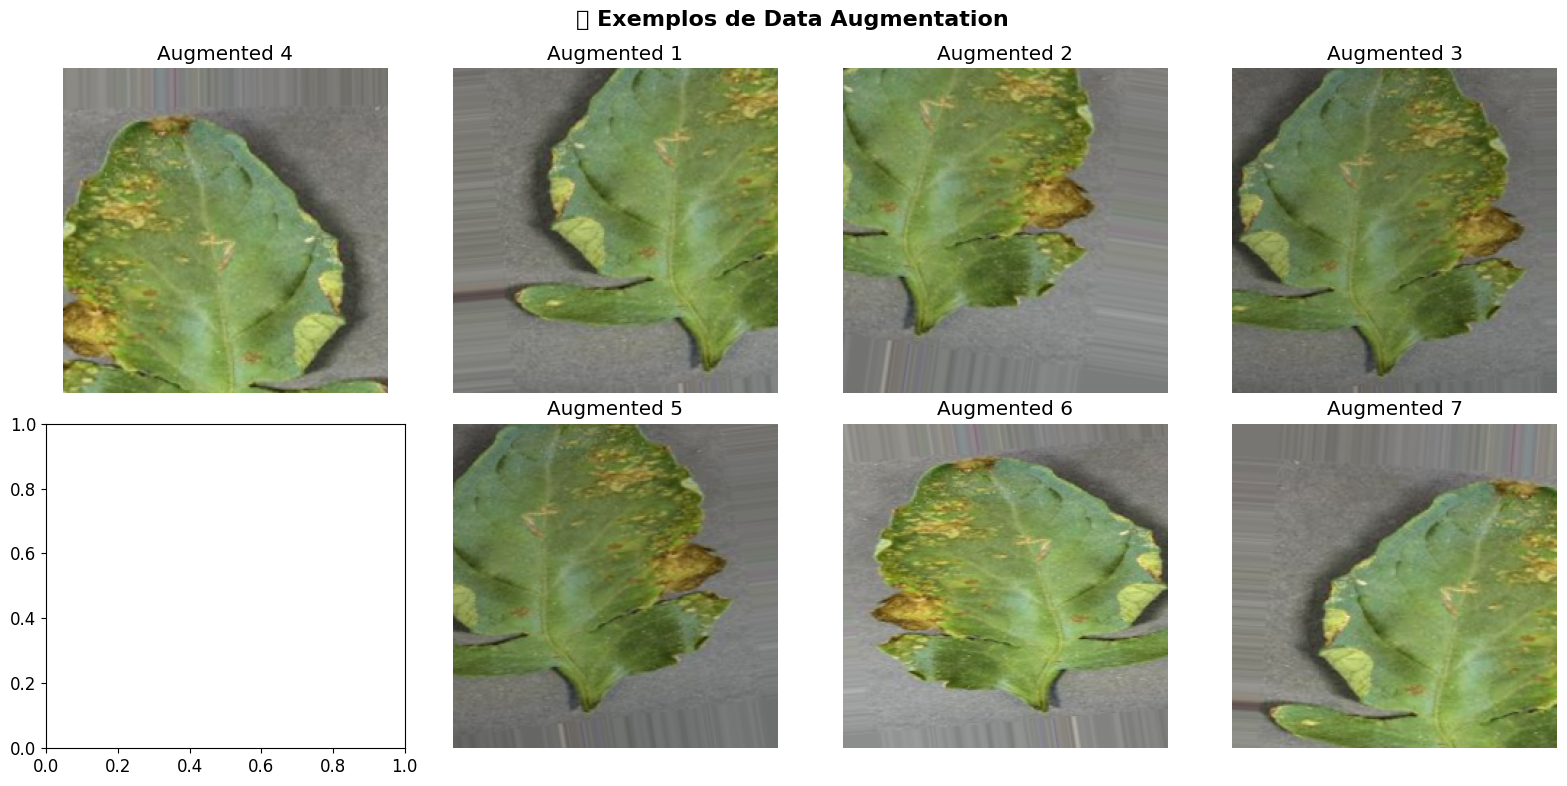

  ✅ Exemplos gerados com sucesso!


In [9]:
# BLOCO 9: Configuração de Data Augmentation
print("🎨 CONFIGURAÇÃO DE DATA AUGMENTATION")
print("=" * 60)

# Data Augmentation para dados de treino
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,           # Normalização
    rotation_range=20,           # Rotação até 20 graus
    width_shift_range=0.2,       # Deslocamento horizontal 20%
    height_shift_range=0.2,      # Deslocamento vertical 20%
    shear_range=0.2,            # Cisalhamento
    zoom_range=0.2,             # Zoom in/out 20%
    horizontal_flip=True,        # Flip horizontal
    vertical_flip=False,         # Sem flip vertical (plantas crescem para cima)
    fill_mode='nearest',         # Preenchimento de pixels
    brightness_range=[0.8, 1.2] # Variação de brilho
)

# Data Augmentation mais suave para validação (apenas normalização)
val_test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

print("✅ Configurações de Data Augmentation criadas:")
print("  🚂 Treino: Augmentation completo (rotação, zoom, flip, brilho)")
print("  🔍 Val/Test: Apenas normalização")

# Visualizar exemplo de data augmentation
print(f"\n🖼️ Testando Data Augmentation:")

# Carregar uma imagem de exemplo
img_exemplo = preprocessar_imagem(caminho_teste)
if img_exemplo is not None:
    # Preparar imagem para o gerador (adicionar dimensão batch)
    img_exemplo_batch = np.expand_dims(img_exemplo * 255, axis=0)  # Reverter normalização temporariamente
    
    # Gerar imagens aumentadas
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('🎨 Exemplos de Data Augmentation', fontsize=16, fontweight='bold')
    
    # Imagem original
    axes[0, 0].imshow(img_exemplo)
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')
    
    # Gerar 7 versões aumentadas
    aug_iter = train_datagen.flow(img_exemplo_batch, batch_size=1)
    
    for i in range(7):
        row = i // 4
        col = (i + 1) % 4
        
        aug_img = next(aug_iter)[0]  # Pegar primeira imagem do batch
        axes[row, col].imshow(aug_img)
        axes[row, col].set_title(f'Augmented {i+1}')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("  ✅ Exemplos gerados com sucesso!")

In [10]:
# BLOCO 10: Criação de geradores para classificação de espécies
print("🌿 CRIANDO GERADORES PARA CLASSIFICAÇÃO DE ESPÉCIES")
print("=" * 60)

# Encoder para labels de espécies
label_encoder_especies = LabelEncoder()
y_train_especies_encoded = label_encoder_especies.fit_transform(y_train_especies)
y_val_especies_encoded = label_encoder_especies.transform(y_val_especies)
y_test_especies_encoded = label_encoder_especies.transform(y_test_especies)

print(f"📋 Mapeamento de labels de espécies:")
for i, classe in enumerate(label_encoder_especies.classes_):
    print(f"  {i}: {classe}")

# Criar DataFrames temporários para os geradores
train_df_especies = pd.DataFrame({
    'filename': X_train_especies,
    'class': y_train_especies
})

val_df_especies = pd.DataFrame({
    'filename': X_val_especies,
    'class': y_val_especies
})

test_df_especies = pd.DataFrame({
    'filename': X_test_especies,
    'class': y_test_especies
})

# Geradores de dados para espécies
BATCH_SIZE = 32

train_generator_especies = train_datagen.flow_from_dataframe(
    train_df_especies,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator_especies = val_test_datagen.flow_from_dataframe(
    val_df_especies,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator_especies = val_test_datagen.flow_from_dataframe(
    test_df_especies,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"✅ Geradores de espécies criados:")
print(f"  🚂 Train: {train_generator_especies.samples} amostras, {len(train_generator_especies)} batches")
print(f"  🔍 Val: {val_generator_especies.samples} amostras, {len(val_generator_especies)} batches")
print(f"  🧪 Test: {test_generator_especies.samples} amostras, {len(test_generator_especies)} batches")
print(f"  📦 Batch size: {BATCH_SIZE}")
print(f"  🏷️ Classes: {list(train_generator_especies.class_indices.keys())}")

🌿 CRIANDO GERADORES PARA CLASSIFICAÇÃO DE ESPÉCIES
📋 Mapeamento de labels de espécies:
  0: Pepper_bell
  1: Potato
  2: Tomato
Found 14446 validated image filenames belonging to 3 classes.
Found 3096 validated image filenames belonging to 3 classes.
Found 3096 validated image filenames belonging to 3 classes.
✅ Geradores de espécies criados:
  🚂 Train: 14446 amostras, 452 batches
  🔍 Val: 3096 amostras, 97 batches
  🧪 Test: 3096 amostras, 97 batches
  📦 Batch size: 32
  🏷️ Classes: ['Pepper_bell', 'Potato', 'Tomato']


In [11]:
# BLOCO 11: Criação de geradores para modelos especialistas
print("🔬 CRIANDO GERADORES PARA MODELOS ESPECIALISTAS")
print("=" * 60)

geradores_especialistas = {}
label_encoders_especialistas = {}

for especie in splits_especialistas.keys():
    print(f"\n🌿 Criando geradores para {especie}:")
    
    splits = splits_especialistas[especie]
    
    # Encoder para labels desta espécie
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(splits['y_train'])
    y_val_encoded = label_encoder.transform(splits['y_val'])
    y_test_encoded = label_encoder.transform(splits['y_test'])
    
    label_encoders_especialistas[especie] = label_encoder
    
    print(f"  📋 Classes encontradas ({len(label_encoder.classes_)}):")
    for i, classe in enumerate(label_encoder.classes_):
        classe_simplificada = classe.replace(f'{especie}_', '').replace('__', '_')
        print(f"    {i}: {classe_simplificada}")
    
    # Criar DataFrames
    train_df = pd.DataFrame({
        'filename': splits['X_train'],
        'class': splits['y_train']
    })
    
    val_df = pd.DataFrame({
        'filename': splits['X_val'],
        'class': splits['y_val']
    })
    
    test_df = pd.DataFrame({
        'filename': splits['X_test'],
        'class': splits['y_test']
    })
    
    # Criar geradores
    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_gen = val_test_datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    test_gen = val_test_datagen.flow_from_dataframe(
        test_df,
        x_col='filename',
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    geradores_especialistas[especie] = {
        'train': train_gen,
        'val': val_gen,
        'test': test_gen
    }
    
    print(f"  ✅ Geradores criados:")
    print(f"    🚂 Train: {train_gen.samples} amostras")
    print(f"    🔍 Val: {val_gen.samples} amostras")
    print(f"    🧪 Test: {test_gen.samples} amostras")

print(f"\n✅ Geradores especialistas criados para {len(geradores_especialistas)} espécies!")

🔬 CRIANDO GERADORES PARA MODELOS ESPECIALISTAS

🌿 Criando geradores para Tomato:
  📋 Classes encontradas (10):
    0: Bacterial_spot
    1: Early_blight
    2: Late_blight
    3: Leaf_Mold
    4: Septoria_leaf_spot
    5: Spider_mites_Two_spotted_spider_mite
    6: _Target_Spot
    7: _YellowLeaf_Curl_Virus
    8: _mosaic_virus
    9: healthy


Found 11207 validated image filenames belonging to 10 classes.
Found 2402 validated image filenames belonging to 10 classes.
Found 2402 validated image filenames belonging to 10 classes.
  ✅ Geradores criados:
    🚂 Train: 11207 amostras
    🔍 Val: 2402 amostras
    🧪 Test: 2402 amostras

🌿 Criando geradores para Potato:
  📋 Classes encontradas (3):
    0: _Early_blight
    1: _Late_blight
    2: _healthy
Found 1506 validated image filenames belonging to 3 classes.
Found 323 validated image filenames belonging to 3 classes.
Found 323 validated image filenames belonging to 3 classes.
  ✅ Geradores criados:
    🚂 Train: 1506 amostras
    🔍 Val: 323 amostras
    🧪 Test: 323 amostras

🌿 Criando geradores para Pepper_bell:
  📋 Classes encontradas (2):
    0: Pepper_bell__Bacterial_spot
    1: Pepper_bell__healthy
Found 1731 validated image filenames belonging to 2 classes.
Found 372 validated image filenames belonging to 2 classes.
Found 372 validated image filenames belonging to 2 classes.

👀 VISUALIZANDO BATCHES DOS GERADORES
🌿 Visualizando batch do classificador de espécies:


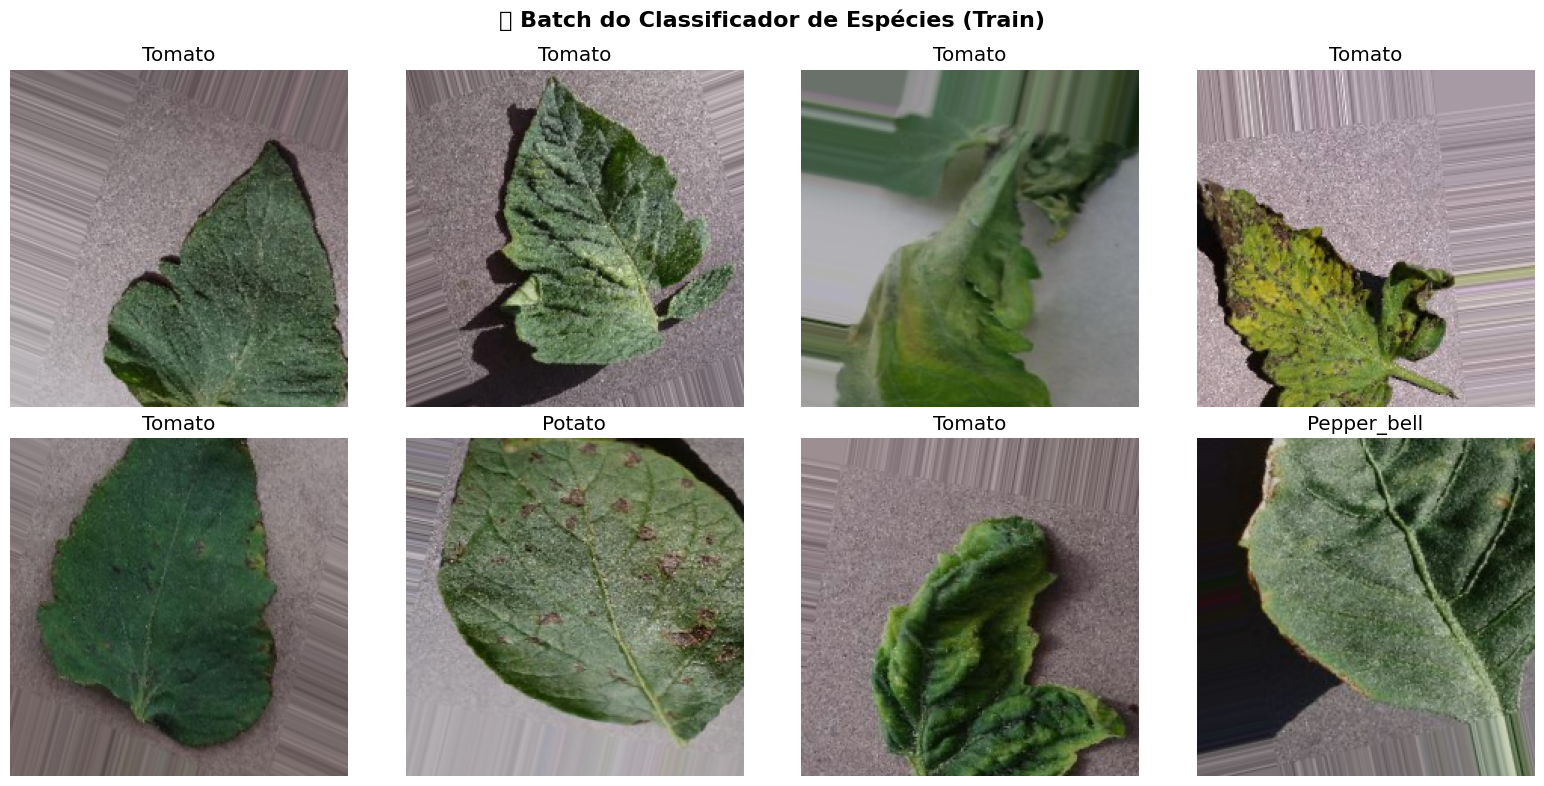


🍅 Visualizando batch do especialista de Tomate:


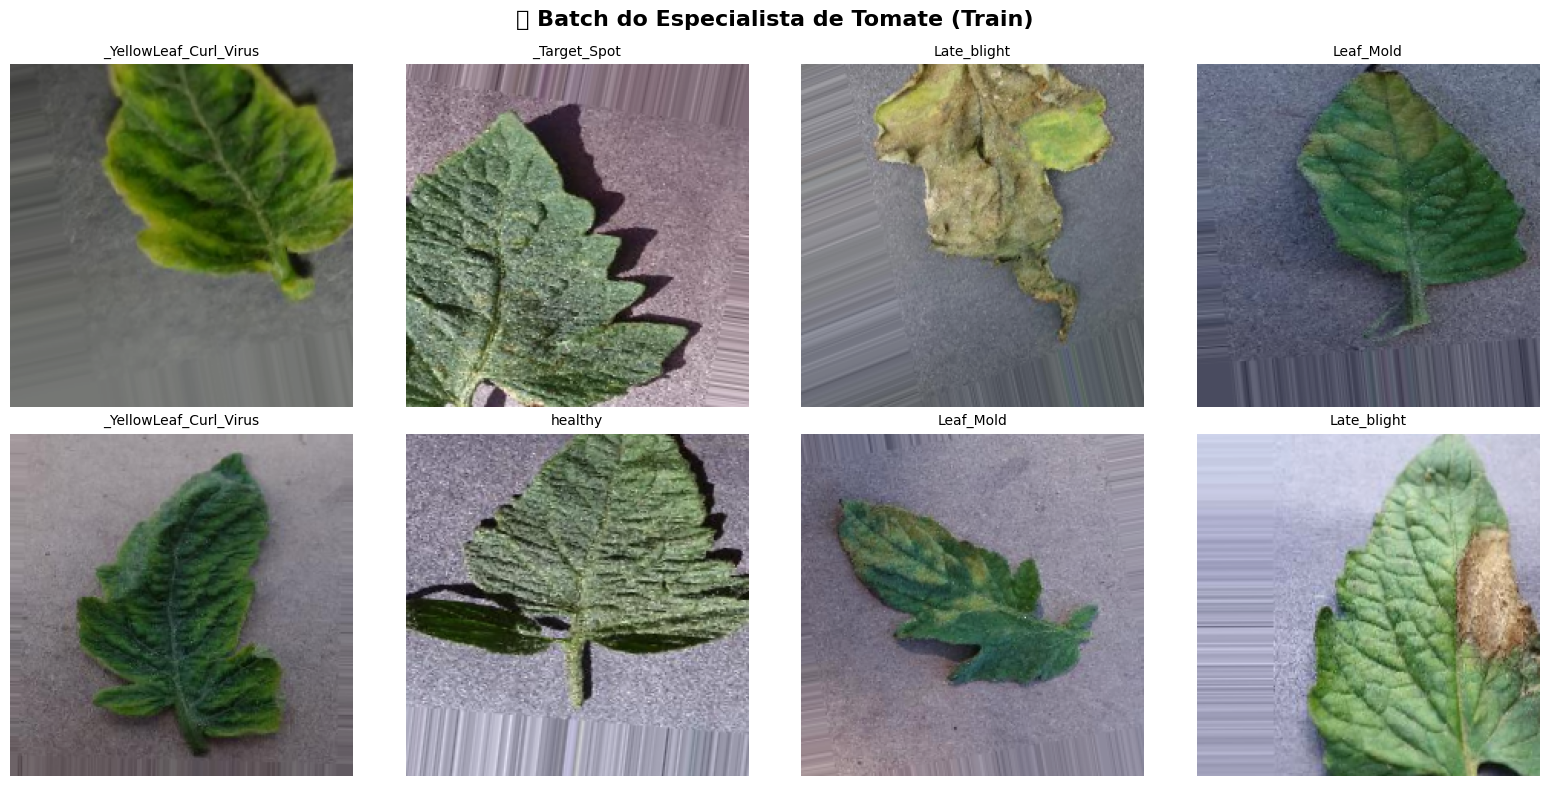

In [12]:
# BLOCO 12: Visualização de batches dos geradores
print("👀 VISUALIZANDO BATCHES DOS GERADORES")
print("=" * 60)

# Visualizar batch do gerador de espécies
print("🌿 Visualizando batch do classificador de espécies:")

batch_x, batch_y = next(train_generator_especies)
class_names_especies = list(train_generator_especies.class_indices.keys())

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('🌿 Batch do Classificador de Espécies (Train)', fontsize=16, fontweight='bold')

for i in range(8):
    row = i // 4
    col = i % 4
    
    img = batch_x[i]
    label_idx = np.argmax(batch_y[i])
    label_name = class_names_especies[label_idx]
    
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'{label_name}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Visualizar batch de um especialista (Tomato se disponível)
if 'Tomato' in geradores_especialistas:
    print(f"\n🍅 Visualizando batch do especialista de Tomate:")
    
    tomato_gen = geradores_especialistas['Tomato']['train']
    batch_x_tomato, batch_y_tomato = next(tomato_gen)
    class_names_tomato = list(tomato_gen.class_indices.keys())
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('🍅 Batch do Especialista de Tomate (Train)', fontsize=16, fontweight='bold')
    
    for i in range(8):
        row = i // 4
        col = i % 4
        
        img = batch_x_tomato[i]
        label_idx = np.argmax(batch_y_tomato[i])
        label_name = class_names_tomato[label_idx].replace('Tomato_', '').replace('__', '_')
        
        axes[row, col].imshow(img)
        axes[row, col].set_title(f'{label_name}', fontsize=10)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

In [13]:
# BLOCO 13: Validação dos geradores e estatísticas finais
print("✅ VALIDAÇÃO FINAL DOS GERADORES")
print("=" * 60)

# Validar gerador de espécies
print("🌿 CLASSIFICADOR DE ESPÉCIES:")
try:
    batch_test = next(train_generator_especies)
    print(f"  ✅ Gerador funcionando corretamente")
    print(f"  📦 Batch shape: X={batch_test[0].shape}, y={batch_test[1].shape}")
    print(f"  📊 Range de valores X: [{batch_test[0].min():.3f}, {batch_test[0].max():.3f}]")
    print(f"  🏷️ Número de classes: {batch_test[1].shape[1]}")
    
    # Reset do gerador
    train_generator_especies.reset()
    
except Exception as e:
    print(f"  ❌ Erro no gerador de espécies: {e}")

# Validar geradores especialistas
print(f"\n🔬 MODELOS ESPECIALISTAS:")
for especie, geradores in geradores_especialistas.items():
    print(f"\n  {especie}:")
    try:
        batch_test = next(geradores['train'])
        print(f"    ✅ Gerador funcionando corretamente")
        print(f"    📦 Batch shape: X={batch_test[0].shape}, y={batch_test[1].shape}")
        print(f"    🏷️ Número de classes: {batch_test[1].shape[1]}")
        
        # Reset do gerador
        geradores['train'].reset()
        
    except Exception as e:
        print(f"    ❌ Erro no gerador de {especie}: {e}")

# Estatísticas finais
print(f"\n📊 RESUMO FINAL:")
print(f"  🌿 Classificador de espécies:")
print(f"    - {len(class_names_especies)} classes de espécies")
print(f"    - {train_generator_especies.samples} imagens de treino")
print(f"    - {val_generator_especies.samples} imagens de validação")
print(f"    - {test_generator_especies.samples} imagens de teste")

total_especialistas = 0
for especie, geradores in geradores_especialistas.items():
    num_classes = len(list(geradores['train'].class_indices.keys()))
    total_especialistas += geradores['train'].samples
    print(f"  🔬 Especialista {especie}:")
    print(f"    - {num_classes} classes de condições")
    print(f"    - {geradores['train'].samples} imagens de treino")

print(f"\n🎯 TOTAL PROCESSADO: {train_generator_especies.samples + total_especialistas} imagens de treino")

✅ VALIDAÇÃO FINAL DOS GERADORES
🌿 CLASSIFICADOR DE ESPÉCIES:
  ✅ Gerador funcionando corretamente
  📦 Batch shape: X=(32, 224, 224, 3), y=(32, 3)
  📊 Range de valores X: [0.000, 1.000]
  🏷️ Número de classes: 3

🔬 MODELOS ESPECIALISTAS:

  Tomato:
    ✅ Gerador funcionando corretamente
    📦 Batch shape: X=(32, 224, 224, 3), y=(32, 10)
    🏷️ Número de classes: 10

  Potato:
    ✅ Gerador funcionando corretamente
    📦 Batch shape: X=(32, 224, 224, 3), y=(32, 3)
    🏷️ Número de classes: 3

  Pepper_bell:
    ✅ Gerador funcionando corretamente
    📦 Batch shape: X=(32, 224, 224, 3), y=(32, 2)
    🏷️ Número de classes: 2

📊 RESUMO FINAL:
  🌿 Classificador de espécies:
    - 3 classes de espécies
    - 14446 imagens de treino
    - 3096 imagens de validação
    - 3096 imagens de teste
  🔬 Especialista Tomato:
    - 10 classes de condições
    - 11207 imagens de treino
  🔬 Especialista Potato:
    - 3 classes de condições
    - 1506 imagens de treino
  🔬 Especialista Pepper_bell:
    - 2 

In [14]:
#Salvamento de configurações para próximos notebooks

print("💾 SALVANDO CONFIGURAÇÕES PARA PRÓXIMOS NOTEBOOKS")

# Configurações importantes para os próximos notebooks
configuracoes_projeto = {
    'img_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'num_classes_especies': len(class_names_especies),
    'class_names_especies': class_names_especies,
    'label_encoder_especies': label_encoder_especies,
    'train_samples_especies': train_generator_especies.samples,
    'val_samples_especies': val_generator_especies.samples,
    'test_samples_especies': test_generator_especies.samples
}

# Configurações dos especialistas
configuracoes_especialistas = {}
for especie in geradores_especialistas.keys():
    geradores = geradores_especialistas[especie]
    configuracoes_especialistas[especie] = {
        'num_classes': len(list(geradores['train'].class_indices.keys())),
        'class_names': list(geradores['train'].class_indices.keys()),
        'label_encoder': label_encoders_especialistas[especie],
        'train_samples': geradores['train'].samples,
        'val_samples': geradores['val'].samples,
        'test_samples': geradores['test'].samples
    }

print("✅ Configurações preparadas:")
print(f"  🌿 Classificador de espécies: {configuracoes_projeto['num_classes_especies']} classes")
for especie, config in configuracoes_especialistas.items():
    print(f"  🔬 {especie}: {config['num_classes']} classes")

print(f"\n🚀 Pronto para o próximo notebook: Treinamento do Classificador de Espécies!")
print(f"\n📋 CHECKLIST PARA PRÓXIMOS PASSOS:")
print(f"  ✅ Dados preprocessados e normalizados")
print(f"  ✅ Data augmentation configurado")
print(f"  ✅ Divisão estratificada train/val/test")
print(f"  ✅ Geradores de dados criados e testados")
print(f"  ✅ Configurações salvas para próximos notebooks")
print(f"  🎯 Próximo: Arquitetura e treinamento dos modelos")

💾 SALVANDO CONFIGURAÇÕES PARA PRÓXIMOS NOTEBOOKS
✅ Configurações preparadas:
  🌿 Classificador de espécies: 3 classes
  🔬 Tomato: 10 classes
  🔬 Potato: 3 classes
  🔬 Pepper_bell: 2 classes

🚀 Pronto para o próximo notebook: Treinamento do Classificador de Espécies!

📋 CHECKLIST PARA PRÓXIMOS PASSOS:
  ✅ Dados preprocessados e normalizados
  ✅ Data augmentation configurado
  ✅ Divisão estratificada train/val/test
  ✅ Geradores de dados criados e testados
  ✅ Configurações salvas para próximos notebooks
  🎯 Próximo: Arquitetura e treinamento dos modelos


In [15]:
#Salvamento dos datasets para reutilização
print("💾 SALVANDO DATASETS PARA REUTILIZAÇÃO")

import json
import pickle

# Criar diretório para salvar os dados
SAVE_DIR = 'datasets_processados'
os.makedirs(SAVE_DIR, exist_ok=True)

# 1. SALVAR DIVISÕES DO DATASET DE ESPÉCIES
print("🌿 Salvando dataset de espécies...")

# DataFrame com todas as divisões de espécies
df_especies_completo = pd.DataFrame({
    'caminho': list(X_train_especies) + list(X_val_especies) + list(X_test_especies),
    'especie': list(y_train_especies) + list(y_val_especies) + list(y_test_especies),
    'split': ['train'] * len(X_train_especies) + ['val'] * len(X_val_especies) + ['test'] * len(X_test_especies)
})

df_especies_completo.to_csv(f'{SAVE_DIR}/dataset_especies.csv', index=False)
print(f"  ✅ Salvo: {SAVE_DIR}/dataset_especies.csv")

# 2. SALVAR DIVISÕES DOS DATASETS ESPECIALISTAS
print(f"\n🔬 Salvando datasets especialistas...")

for especie, splits in splits_especialistas.items():
    df_especialista = pd.DataFrame({
        'caminho': list(splits['X_train']) + list(splits['X_val']) + list(splits['X_test']),
        'classe': list(splits['y_train']) + list(splits['y_val']) + list(splits['y_test']),
        'split': ['train'] * len(splits['X_train']) + ['val'] * len(splits['X_val']) + ['test'] * len(splits['X_test'])
    })
    
    arquivo = f'{SAVE_DIR}/dataset_{especie.lower()}.csv'
    df_especialista.to_csv(arquivo, index=False)
    print(f"  ✅ Salvo: {arquivo}")

# 3. SALVAR CONFIGURAÇÕES DO PROJETO
print(f"\n⚙️ Salvando configurações...")

configuracoes_completas = {
    'img_height': IMG_HEIGHT,
    'img_width': IMG_WIDTH,
    'img_channels': IMG_CHANNELS,
    'batch_size': BATCH_SIZE,
    'random_state': RANDOM_STATE,
    'base_path': BASE_PATH,
    
    # Configurações de espécies
    'especies': {
        'classes': class_names_especies,
        'num_classes': len(class_names_especies),
        'train_samples': train_generator_especies.samples,
        'val_samples': val_generator_especies.samples,
        'test_samples': test_generator_especies.samples
    },
    
    # Configurações de especialistas
    'especialistas': {}
}

for especie in geradores_especialistas.keys():
    geradores = geradores_especialistas[especie]
    configuracoes_completas['especialistas'][especie] = {
        'classes': list(geradores['train'].class_indices.keys()),
        'num_classes': len(list(geradores['train'].class_indices.keys())),
        'train_samples': geradores['train'].samples,
        'val_samples': geradores['val'].samples,
        'test_samples': geradores['test'].samples
    }

# Salvar como JSON
with open(f'{SAVE_DIR}/configuracoes.json', 'w') as f:
    json.dump(configuracoes_completas, f, indent=2)

print(f"  ✅ Salvo: {SAVE_DIR}/configuracoes.json")

# 4. SALVAR LABEL ENCODERS
print(f"\n🏷️ Salvando label encoders...")

# Salvar encoder de espécies
with open(f'{SAVE_DIR}/label_encoder_especies.pkl', 'wb') as f:
    pickle.dump(label_encoder_especies, f)

# Salvar encoders de especialistas
for especie, encoder in label_encoders_especialistas.items():
    with open(f'{SAVE_DIR}/label_encoder_{especie.lower()}.pkl', 'wb') as f:
        pickle.dump(encoder, f)

print(f"  ✅ Label encoders salvos")

print(f"\n🎉 TODOS OS DATASETS SALVOS EM: {SAVE_DIR}/")
print(f"📁 Arquivos criados:")
for arquivo in os.listdir(SAVE_DIR):
    print(f"  - {arquivo}")

💾 SALVANDO DATASETS PARA REUTILIZAÇÃO
🌿 Salvando dataset de espécies...
  ✅ Salvo: datasets_processados/dataset_especies.csv

🔬 Salvando datasets especialistas...
  ✅ Salvo: datasets_processados/dataset_tomato.csv
  ✅ Salvo: datasets_processados/dataset_potato.csv
  ✅ Salvo: datasets_processados/dataset_pepper_bell.csv

⚙️ Salvando configurações...
  ✅ Salvo: datasets_processados/configuracoes.json

🏷️ Salvando label encoders...
  ✅ Label encoders salvos

🎉 TODOS OS DATASETS SALVOS EM: datasets_processados/
📁 Arquivos criados:
  - dataset_pepper_bell.csv
  - label_encoder_tomato.pkl
  - dataset_especies.csv
  - label_encoder_especies.pkl
  - label_encoder_potato.pkl
  - label_encoder_pepper_bell.pkl
  - dataset_tomato.csv
  - dataset_potato.csv
  - configuracoes.json
